# WET-007: Compare CWFS approaches with WET-001 ComCam data


Owner: **Chris  Suberlak** [@suberlak](https://github.com/lsst-ts/ts_aos_analysis/issues/new?body=@suberlak) <br>
Last Verified to Run: **2024-11-05** <br>
Software Version:
  - `ts_wep`: **12.5.0**
  - `lsst_distrib`: **w_2024_44**

Use WET-001 LsstComCam data. As for LsstCam, it is a simulation of 100 random states, with intra, extra, and in-focus positions.  

## Imports 

In [1]:
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
import numpy as np


## Employ the central butler repository  to ingest raws,  perform ISR, and run WEP.

    butler register-instrument /sdf/data/rubin/repo/aos_imsim lsst.obs.lsst.LsstComCam 
    
    butler ingest-raws /sdf/data/rubin/repo/aos_imsim/ /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_comcam/state_*/amp* --update-records -t direct
    
    butler write-curated-calibrations /sdf/data/rubin/repo/aos_imsim  lsst.obs.lsst.LsstComCam 
    
    butler define-visits /sdf/data/rubin/repo/aos_imsim   lsst.obs.lsst.LsstComCam


In   `/sdf/group/rubin/shared/scichris/DM-46763_WET-007`,  make `site_bps.yaml`, containing  


    site:
      s3df:
        profile:
          condor:
            +Walltime: 7200

In [2]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('raw', collections=['LSSTComCam/raw/all'],
                             where=f"instrument='LSSTComCam' and visit.day_obs = 20240723 and exposure.science_program = '1'").expanded()
print(len(list(dataRefs)))
refs = []
for ref in dataRefs:
    refs.append(ref)

2640


We're short of 9x300 = 2700, because for some optical states not all detectors got simulated. 

Run ISR on all states:

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007

    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:commissioning


    description: basic ISR
    # Here we specify the corresponding instrument for the data we
    # will be using.
    instrument: lsst.obs.lsst.LsstComCam
    # Then we can specify each task in our pipeline by a name
    # and then specify the class name corresponding to that task
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        # Below we specify the configuration settings we want to use
        # when running the task in this pipeline. Since our data doesn't
        # include bias or flats we only want to use doApplyGains and
        # doOverscan in our isr task.
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: True
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'

      
    
    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim -i  LSSTComCam/raw/all,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_ISR -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineISR.yaml  -d "instrument='LSSTComCam' and exposure.science_program = '1'"


In [3]:
collection = 'WET-001_lsstComCam_ISR'
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=[collection],
                             where=f"instrument='LSSTComCam' and exposure.day_obs = 20240723").expanded()
print(len(list(dataRefs)))

2640


We use the following pipelines: 

* TIE pipeline (`lsstComCamPipelineDonutsZernikesTIE.yaml`)

    
    
        description: run pipeline from ISR to Zk with TIE
        
        # Here we specify the corresponding instrument for the data we
        # will be using.
        instrument: lsst.obs.lsst.LsstComCam
        
        # Then we can specify each task in our pipeline by a name
        # and then specify the class name corresponding to that task
        tasks:
          generateDonutDirectDetectTask:
            class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
            config:
              donutSelector.useCustomMagLimit: True
              measurementTask.nSigmaDetection: 5
          cutOutDonutsScienceSensorGroupTask::
            class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
          calcZernikesTask:
            class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask



* Danish pipeline (`lsstComCamPipelineDonutsZernikesDanish.yaml`):

    
        description: run pipeline from ISR to Zk with Danish
        
        # Here we specify the corresponding instrument for the data we
        # will be using.
        instrument: lsst.obs.lsst.LsstComCam
        
        # Then we can specify each task in our pipeline by a name
        # and then specify the class name corresponding to that task
        tasks:
          generateDonutDirectDetectTask:
            class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
            config:
              donutSelector.useCustomMagLimit: True
              measurementTask.nSigmaDetection: 5
          cutOutDonutsScienceSensorTask::
            class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
          calcZernikesTask:
            class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
            config:
               python: |
                  from lsst.ts.wep.task import EstimateZernikesTieTask, EstimateZernikesDanishTask
                  config.estimateZernikes.retarget(EstimateZernikesDanishTask)

They are run with following commands: 

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007/
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:commissioning

   
    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_TIE_6001_6200_bps  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesTIE.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723" 

    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstComCam_ISR,LSSTComCam/calib/unbounded -o WET-001_lsstComCam_Danish_6001_6200_bps  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstComCamPipelineDonutsZernikesDanish.yaml -d "instrument='LSSTComCam' and exposure.day_obs = 20240723"



## Inspect the results 

In [5]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('zernikeEstimateRaw', 
                                         collections=['WET-001_lsstComCam_TIE_6001_6200_bps']
                                        ).expanded()
print(len(list(dataRefs)))

861


Given that, plot the comparison in fit results between Danish and TIE:

In [6]:
# store all Danish vs TIE in a dictionary 
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
output_collection = 'WET-001_lsstComCam_TIE_6001_6200_bps'
datasetRefs = list(registry.queryDatasets('zernikeEstimateAvg', collections=[output_collection],
                                     ).expanded())
seqs = np.array([int(str(ref.dataId.visit.seq_num)[1:]) for ref in datasetRefs])
states = np.unique(np.array((seqs+1) / 2).astype(int) )

results = {'tie':{}, 'danish':{}}
for method in results.keys():
    results[method] = {}
    for state in states:
        results[method][state] = {}
        for raft in range(9):
            results[method][state][raft] = {}

for ref in datasetRefs:
    # read in the results of each method 
    for method in results.keys():
        if method == 'tie':
            coll_method = 'TIE'  
        else:
            coll_method = 'Danish'
        output_collection = f'WET-001_lsstComCam_{coll_method}_6001_6200_bps'
        seq_num = int(str(ref.dataId.visit.seq_num)[1:])
        state = int((seq_num+1)/2)
        raft = ref.dataId.detector.id
        results[method][state][raft]['zernikeEstimateAvg'] =  butler.get('zernikeEstimateAvg', 
                          dataId=ref.dataId, 
                          collections=[output_collection])
        results[method][state][raft]['zernikeEstimateRaw'] =  butler.get('zernikeEstimateRaw', 
                          dataId=ref.dataId, 
                          collections=[output_collection])
        results[method][state][raft]['zernikes'] =  butler.get('zernikes', 
                          dataId=ref.dataId, 
                          collections=[output_collection])
        results[method][state][raft]['dataId'] = ref.dataId

To compare TIE vs Danish, we first plot the actual fit results for each detector for a single optical state:

In [12]:
def plot_fit(state, results):
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)

    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for i in range(9):
        
        ax[i].set_title(i )
        
        for method in results.keys():
            # plot  averaged zks for danish and tie
            zkAvg = results[method][state][i]['zernikeEstimateAvg']
            ax[i].plot(np.arange(4,29), zkAvg[0], marker='d', label=f'{method} ')
          
        ax[i].set_xticks(np.arange(4,29,step=2))
        ax[i].axhline(0,ls='--', c='red')
        ax[i].legend()
       
    fig.text(0.5,0.05, 'Zk mode')
    fig.text(0.05,0.5, 'Zk value [microns]', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'WET-007 comCam, state {state}, \n : TIE vs Danish')

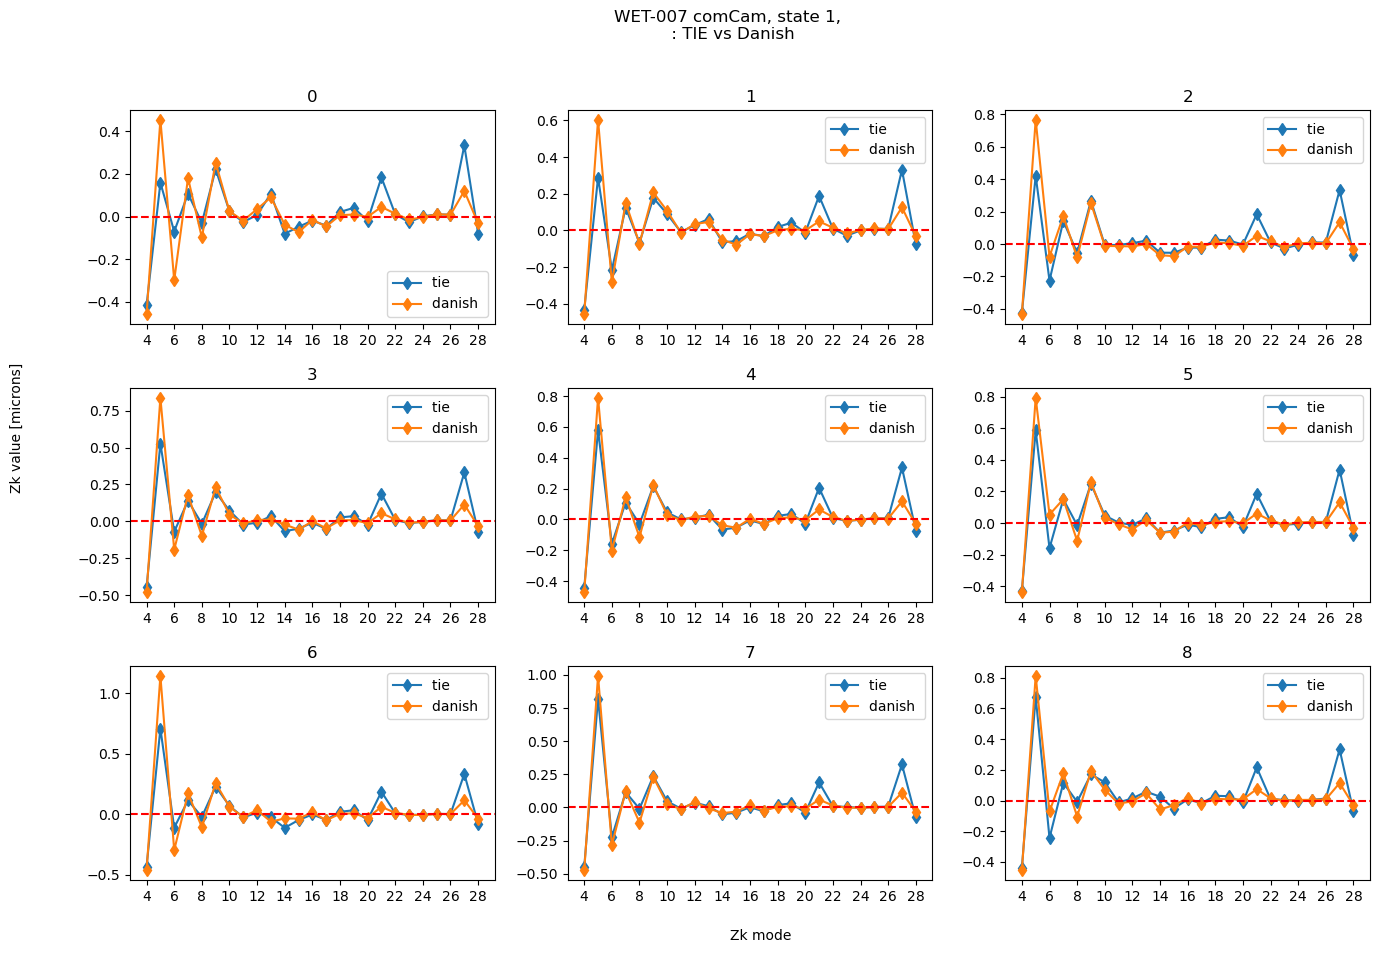

In [13]:
plot_fit(1, results)

Add information coming from scatter of individual fit results. This could be either a scatter of raw Zernike estimates per detector that got averaged,  or scatter in values of averaged Zernikes across detectors.

Illustrate first method: scatter in fit results from donuts that were accepted to contribute to the `zernikeEstimateAvg`. On the figure below the average result (solid green line) is an aggregate (median) of individual estimates from all selected donut pairs  per  exposure. We use the standard deviation of the scatter per mode as one possible proxy for the measurement uncertainty. 


Text(0.5, 1.0, 'Optical state 96, detector 8, Danish')

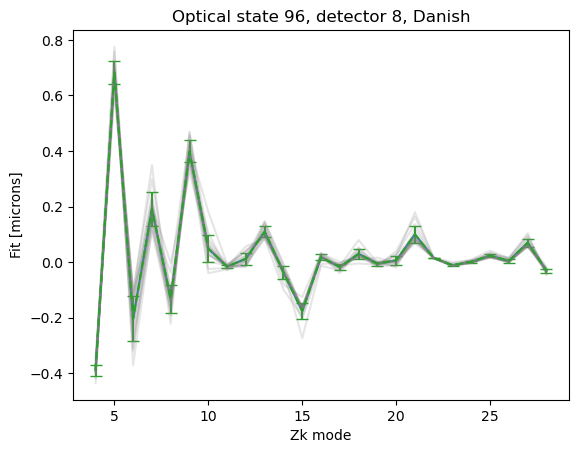

In [14]:
zkr = butler.get('zernikeEstimateRaw', dataId=ref.dataId,   collections=[output_collection])
zka = butler.get('zernikeEstimateAvg', dataId=ref.dataId,   collections=[output_collection])
zks = butler.get('zernikes', dataId=ref.dataId,    collections=[output_collection])
mask_used = zks['used'][1:]
zkr_used = zkr[mask_used]

plt.plot(np.arange(4,29), zka[0])
plt.errorbar(np.arange(4, 29), zka[0], yerr=np.std(zkr_used, axis=0), ls="--", c="C2", label="TIE", capsize=4)
for i in range(len(zkr_used)):
    plt.plot(np.arange(4,29), zkr_used[i], alpha=0.2,c='grey')
plt.xlabel('Zk mode')
plt.ylabel('Fit [microns]')
plt.title(f'Optical state {state}, detector {raft}, {coll_method}')


We plot that for all detectors for a single state, to show that  the two methods have yield very similar results:

In [15]:
def plot_fit_errorbar(state, results):
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)

    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for i in range(9):
        
        ax[i].set_title(i )
        
        for method in results.keys():
            # plot  averaged zks for danish and tie
            zkAvg = results[method][state][i]['zernikeEstimateAvg']
            zkRaw = results[method][state][i]['zernikeEstimateRaw']
            zks = results[method][state][i]['zernikes']
            mask_used = zks['used'][1:]
            zkr_used = zkRaw[mask_used]
            
            #ax[i].plot(np.arange(4,29), zkAvg[0], marker='d', label=f'{method} ')
            ax[i].errorbar(np.arange(4, 29), zkAvg[0], yerr=np.std(zkr_used, axis=0), 
                          label=f'{method} ', capsize=4)
            
        ax[i].set_xticks(np.arange(4,29,step=2))
        ax[i].axhline(0,ls='--', c='red')
        ax[i].legend()
       
    fig.text(0.5,0.05, 'Zk mode')
    fig.text(0.05,0.5, 'Zk value [microns]', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'WET-007 comCam, state {state}, \n : TIE vs Danish')

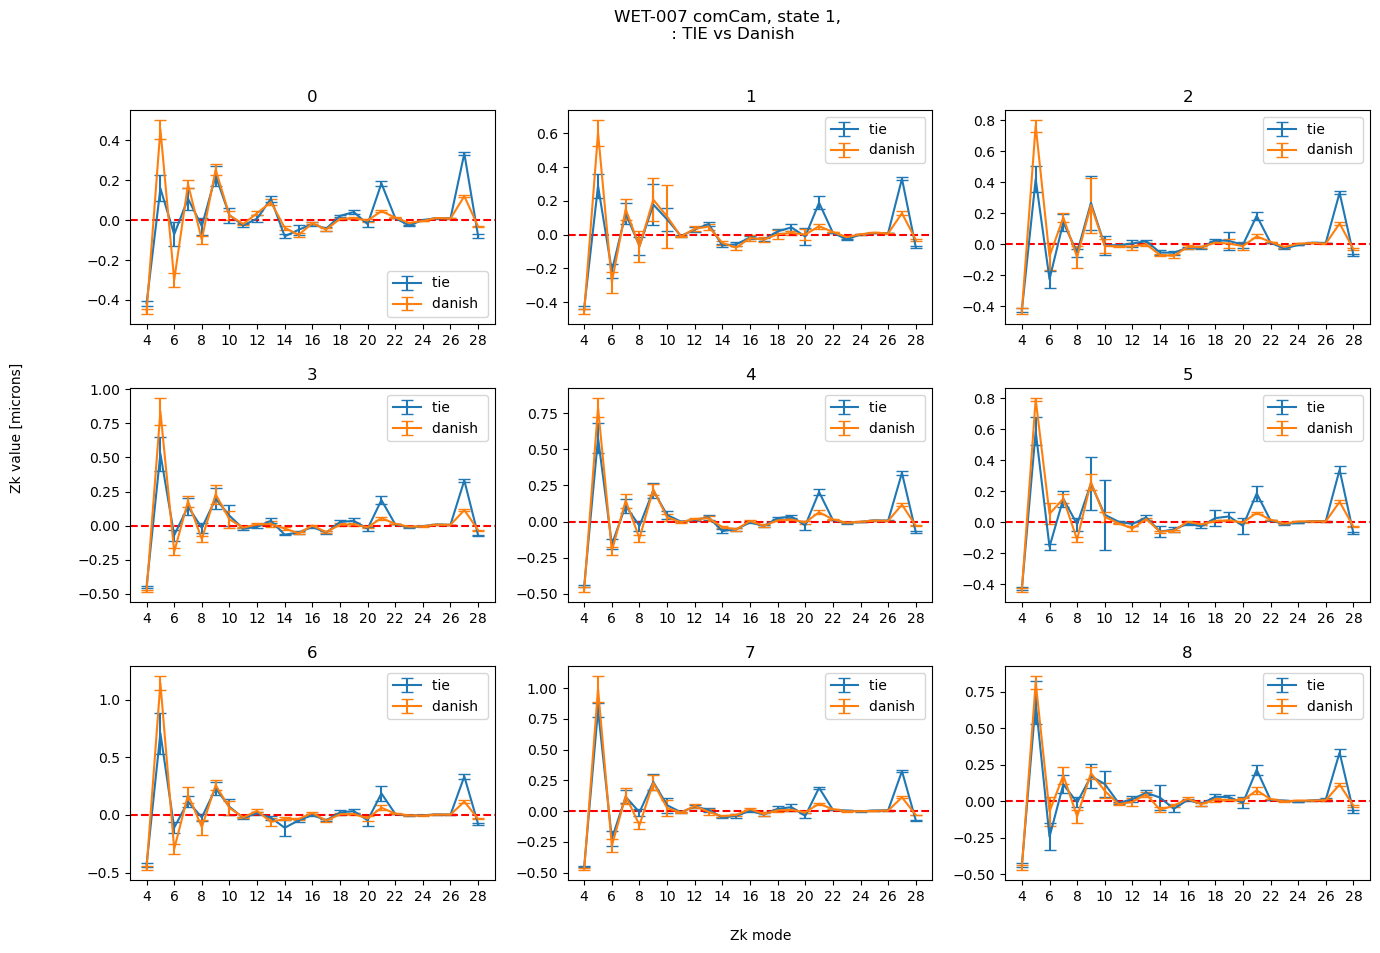

In [16]:
plot_fit_errorbar(1, results)

Illustrate the difference between the two methods:

In [21]:
def plot_diff(state, results):
    fig,axs = plt.subplots(3,3,figsize=(16,10))
    ax = np.ravel(axs)

    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for i in range(9):
        
        ax[i].set_title(i )
    
        # plot  difference for danish and tie
        zk1 = results['danish'][state][i]['zernikeEstimateAvg'][0]
        zk2 = results['tie'][state][i]['zernikeEstimateAvg'][0]
        ax[i].plot(np.arange(4,29),zk1-zk2, marker='d', label=f'{method} ')
      
        ax[i].set_xticks(np.arange(4,29,step=2))
        ax[i].axhline(0,ls='--', c='red')
        #ax[i].legend()
       
    fig.text(0.5,0.05, 'Zk mode')
    fig.text(0.05,0.5, f'$\Delta$ zk fit (Danish-TIE) [microns]', rotation='vertical')
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'WET-007 comCam, state {state}, \n : TIE vs Danish')

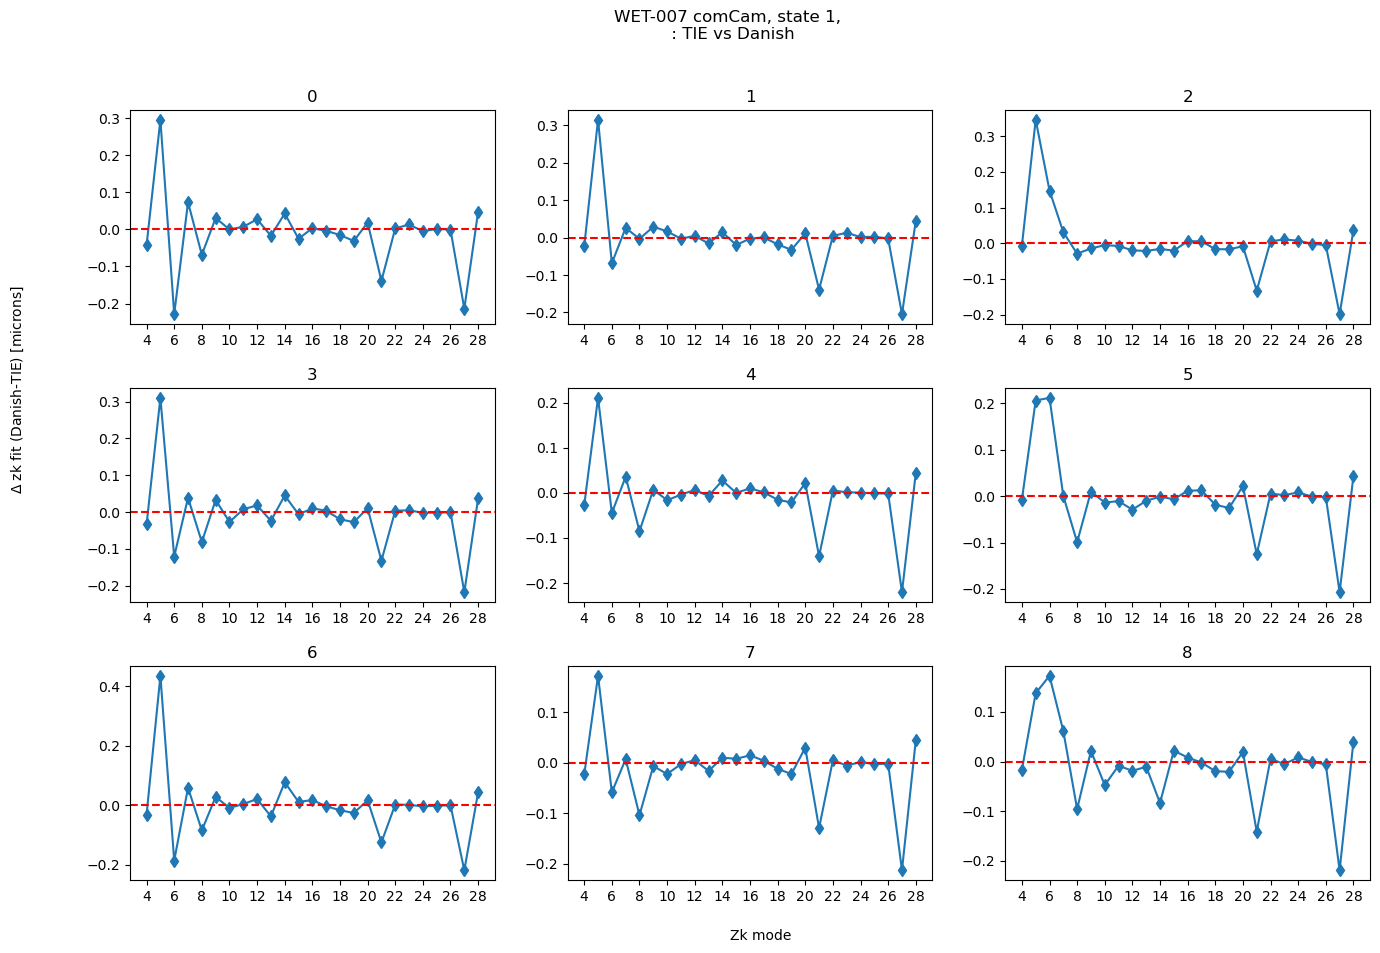

In [22]:
plot_diff(1, results)

Calculate the RMS difference between TIE and Danish per detector per state: 

In [25]:
rmss={}
states = {}
rmserrDanish = {}
rmserrTie = {}

sumErrDanish  = {}
sumErrTie = {}
for raft in range(9):
   rmss[raft] = []
   states[raft] = [] 
   rmserrDanish[raft] = []
   rmserrTie[raft] = []
   sumErrDanish[raft] = []
   sumErrTie[raft]=[]
   for state in range(1,101):
        #print(raft, state)
        cond1 = len(results['danish'][state][raft])>1
        cond2 = len(results['tie'][state][raft])>1
        if cond1 and cond2 : 
            # calculate RMS difference between two estimates of Zk fits 
            zk1 = results['danish'][state][raft]['zernikeEstimateAvg'][0]
            zk2 = results['tie'][state][raft]['zernikeEstimateAvg'][0]
            rms_diff =  np.sqrt(np.mean(np.square(zk1-zk2)))
            rmss[raft].append(rms_diff)
            states[raft].append(state)

            # calculate RMS of uncertainties 
            for method, rmsDict, sumDict in zip(['danish', 'tie'],
                                       [rmserrDanish, rmserrTie],
                                        [sumErrDanish, sumErrTie]
                                      ):
                zkRaw = results[method][state][raft]['zernikeEstimateRaw']
                zks = results[method][state][raft]['zernikes']
                mask_used = zks['used'][1:]
                zkr_used = zkRaw[mask_used]
                zkErr = np.std(zkr_used, axis=0) # uncertainty per Zk mode
                rmsErr = np.sqrt(np.mean(np.square(zkErr))) # single number 
                rmsDict[raft].append(rmsErr) 
                sumDict[raft].append(np.sqrt(np.sum(np.square(zkErr)))) 

            if rms_diff > 10:
                print(method, raft, state, rms_diff)

tie 1 45 608.7696423542536


The total error per detector per state is the sum of variances. This is done for Danish and TIE:

$$
\sigma_{ttl}^{2} = \sum_{i=4}^{i=28}{\sigma_{i}^{2}}
$$

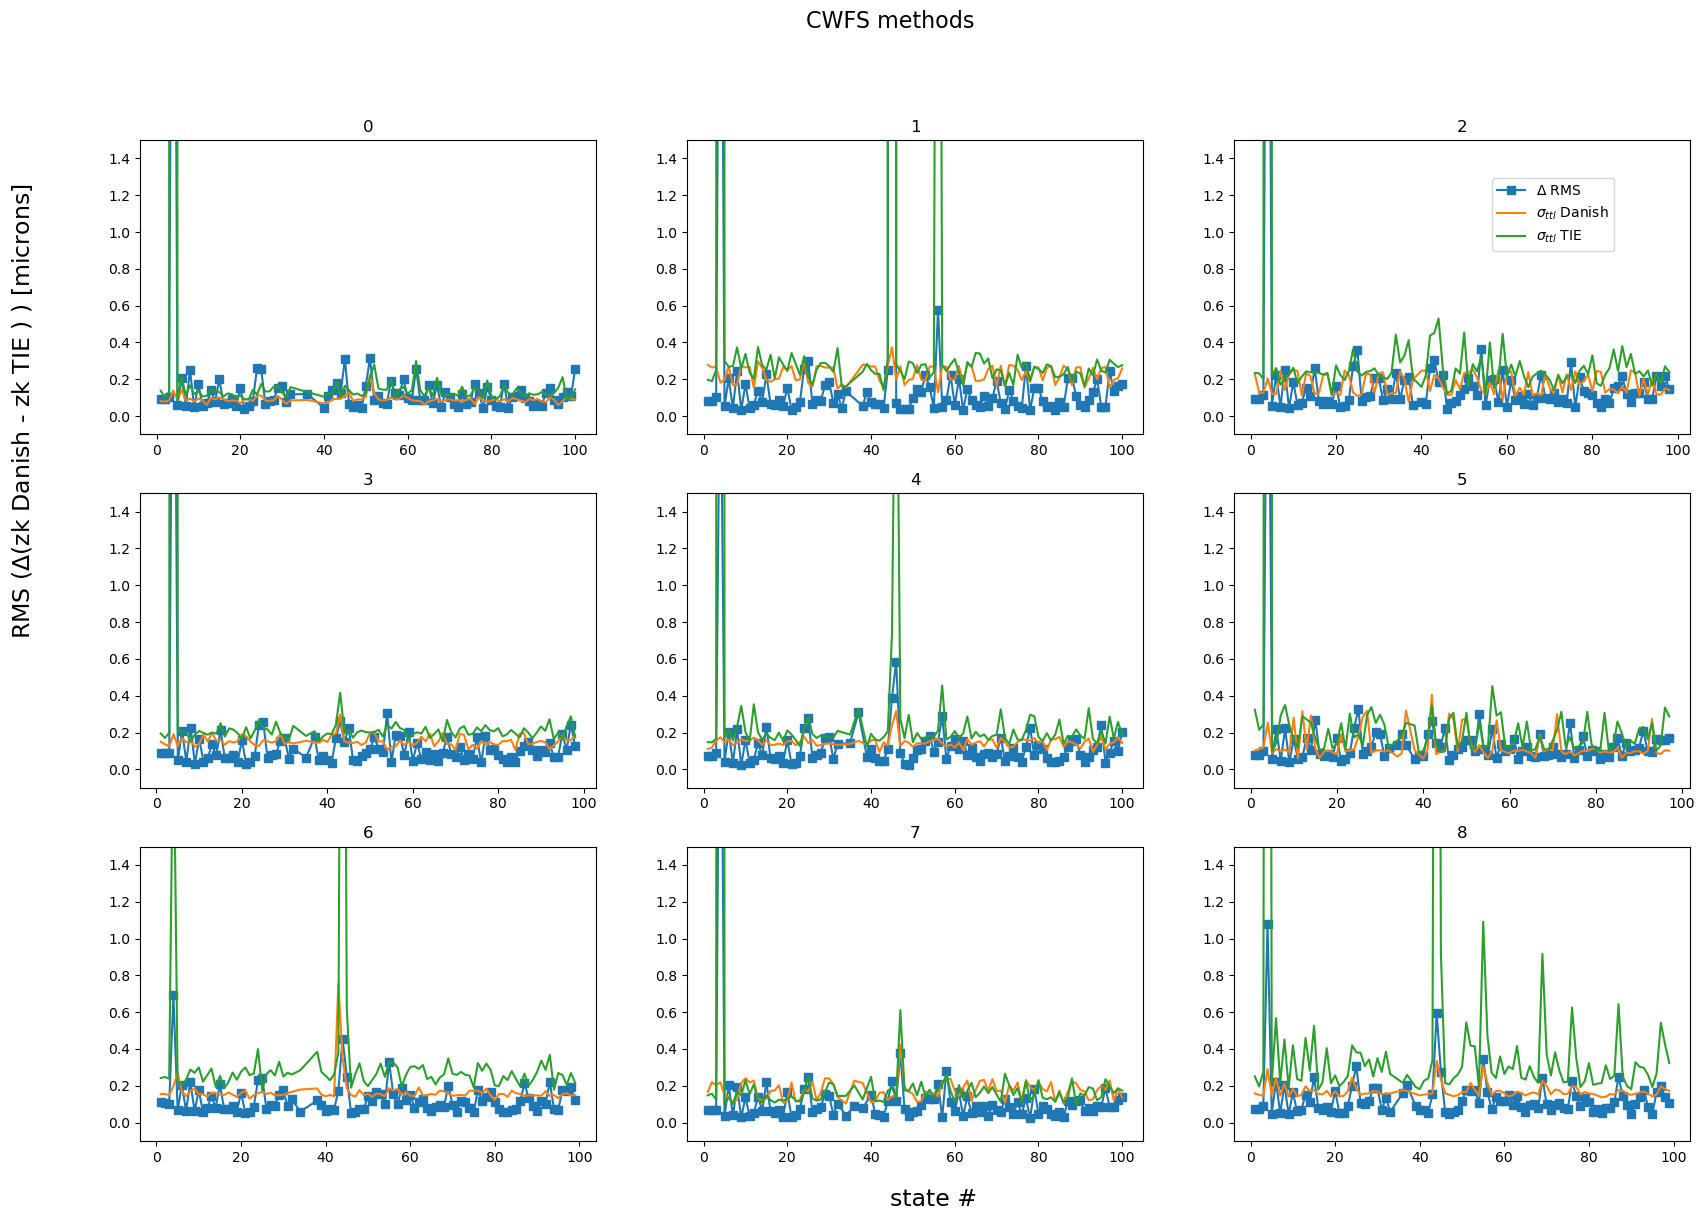

In [26]:
fig,axs = plt.subplots(3,3,figsize=(20,13))
ax = np.ravel(axs)

for raft in range(9):
    ax[raft].plot(states[raft], rmss[raft], marker='s', label=r'$\Delta$ RMS')
    ax[raft].plot(states[raft], sumErrDanish[raft], label=r'$\sigma_{ttl}$ Danish') 
    ax[raft].plot(states[raft], sumErrTie[raft], label=r'$\sigma_{ttl}$ TIE') 
    ax[raft].set_title(raft)
    ax[raft].set_ylim(-0.1,1.5)
   
fig.text(0.5,0.06,'state #', fontsize=17)
fig.text(0.06,0.5,r'RMS ($\Delta$(zk Danish - zk TIE ) ) [microns] ', rotation=90, fontsize=17)
fig.suptitle('CWFS methods', fontsize=16)
ax[2].legend(bbox_to_anchor=[0.55,.6])

For most simulated states, the agreement is at 0.1 microns rms. Inspect those which have a large TIE error (that also corresponds to largest difference in fit results).

Which state has such high error for TIE in raft 0? 

In [27]:
raft = 0
np.array(states[raft])[np.array(rmserrTie[raft]) > 0.5]

array([4])

Plot in detail this state: 

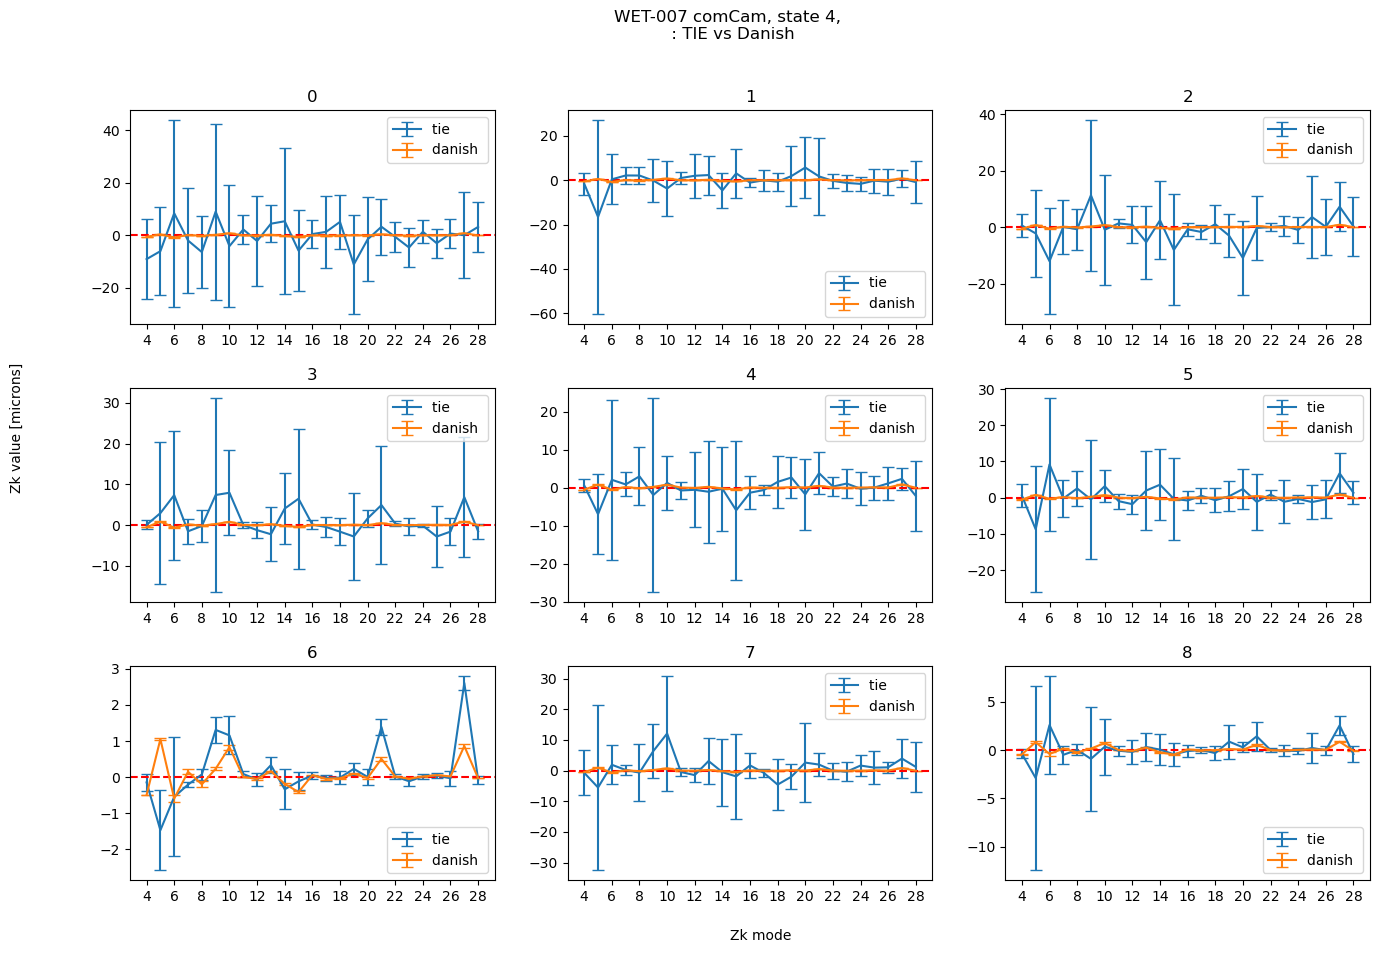

In [28]:
plot_fit_errorbar(4, results)

Plot donut stamps for that state:

In [31]:
state=4
results['tie'][state][0]['dataId']

{instrument: 'LSSTComCam', detector: 0, visit: 5024072306007, band: 'r', day_obs: 20240723, physical_filter: 'r_03'}

In [32]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
output_collection = 'WET-001_lsstComCam_TIE_6001_6200_bps'

donutStampsExtra = butler.get('donutStampsExtra', collections=[output_collection],
                              dataId=results['tie'][state][0]['dataId']
                             )

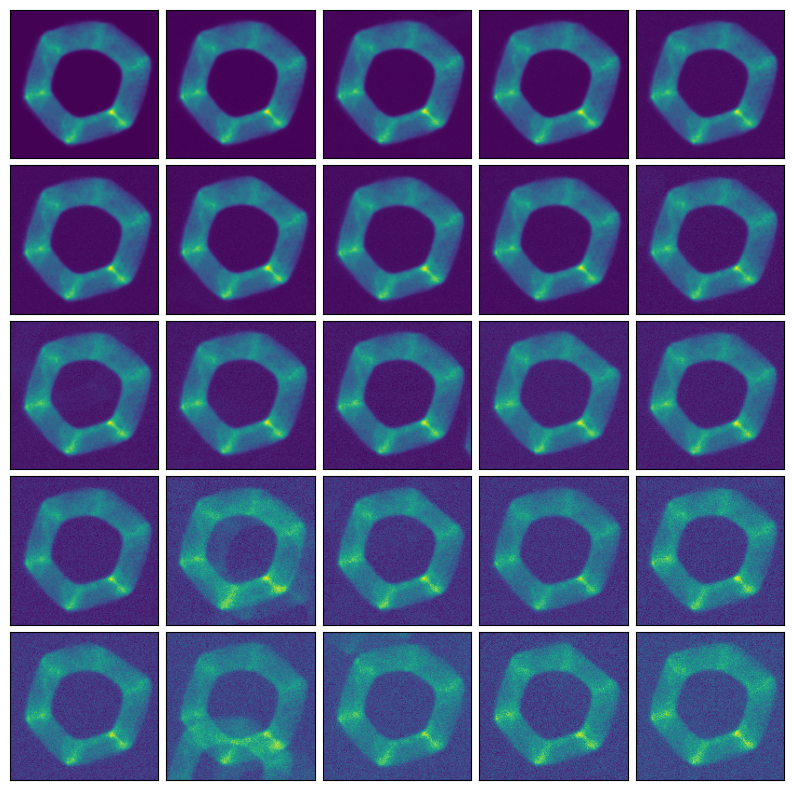

In [35]:
fig,axs = plt.subplots(5,5, figsize=(10,10))
ax = np.ravel(axs)
i=0
donutStamps = donutStampsExtra
for stamp in donutStamps:
    if i < len(ax):
        ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        i += 1 
fig.subplots_adjust(hspace=0.05, wspace=0.05)

if len(donutStamps)<len(ax):
    for i in range(len(donutStamps), len(ax)):
        ax[i].axis('off')

We see that the main disagreement corresponds to very heavily distorted donuts where TIE essentially fails. In such cases it would be recommended to run Danish as  well as it may yield more constrained results. 